# 1. Data Reading, Merge and Pre-clean

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import scipy.stats as stats
import re
import glob
import os
import nltk
import ssl
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sunjinuo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sunjinuo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sunjinuo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1.1 ETL (Extract, Transform, Load)

In [3]:
consumer_prob = pd.read_csv('../data/tables/consumer_fraud_probability.csv')
merchant_prob = pd.read_csv('../data/tables/merchant_fraud_probability.csv')

consumer_details = pd.read_parquet('../data/tables/consumer_user_details.parquet')

transaction_21_08 = pd.read_parquet('../data/tables/transactions_20210228_20210827_snapshot')
transaction_22_02 = pd.read_parquet('../data/tables/transactions_20210828_20220227_snapshot')
transaction_22_08 = pd.read_parquet('../data/tables/transactions_20220228_20220828_snapshot')

tbl_consumer = pd.read_csv('../data/tables/tbl_consumer.csv')
tbl_merchants = pd.read_parquet('../data/tables/tbl_merchants.parquet')

In [3]:
# TODO: use this way to read all the files in the folder
# a way to automatically read all the files in the folder
folder_path = '../data/tables/'
all_files = glob.glob(folder_path + '*')
file_dataframes = {}  # dictionary for files and corresponding dfs/sdfs

for file_path in all_files:
    file_name = os.path.splitext(os.path.basename(file_path))[0]

    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith('.parquet'):
        df = pd.read_parquet(file_path)
    else:
        continue
    
    file_dataframes[file_name] = df

In [4]:
merchant_prob

,merchant_abn,order_datetime,fraud_probability
0,19492220327,2021-11-28,44.403659
1,31334588839,2021-10-02,42.755301
2,19492220327,2021-12-22,38.867790
3,82999039227,2021-12-19,94.134700
4,90918180829,2021-09-02,43.325517
...,...,...,...
109,80089686333,2021-09-01,67.505811
110,83220249221,2021-11-27,63.512459
111,85482742429,2021-11-27,70.881311
112,11470993597,2021-09-28,63.377344


In [5]:
# transaction data concat
transaction = pd.concat([transaction_21_08, transaction_22_02, transaction_22_08])
transaction.to_parquet('../data/curated/transaction/transaction_merged.parquet')

### 1.1.1 Merchant Data Cleaning: Extract tags from table 

In [6]:
# original tbl_merchants
tbl_merchants

,name,tags
merchant_abn,,
10023283211,Felis Limited,"((furniture, home furnishings and equipment sh..."
10142254217,Arcu Ac Orci Corporation,"([cable, satellite, and otHer pay television a..."
10165489824,Nunc Sed Company,"([jewelry, watch, clock, and silverware shops]..."
10187291046,Ultricies Dignissim Lacus Foundation,"([wAtch, clock, and jewelry repair shops], [b]..."
10192359162,Enim Condimentum PC,"([music shops - musical instruments, pianos, a..."
...,...,...
99938978285,Elit Dictum Eu Ltd,"[(opticians, optical goods, and eyeglasses), (..."
99974311662,Mollis LLP,"((books, periodicals, and newspapers), (b), (t..."
99976658299,Sociosqu Corp.,"((shoe shops), (a), (take rate: 6.57))"


In [7]:
# Extract tags from tbl_merchants
tbl_merchants['tags'] = tbl_merchants['tags'].str.findall(r'[\(\[]+([^\)\]]*)[\)\]]')

tbl_merchants[['goods', 'revenue_level', 'take_rate']] = tbl_merchants['tags'] \
                                .apply(lambda x: pd.Series(x) if isinstance(x, list) else [None, None, None])
tbl_merchants['take_rate'] = tbl_merchants['take_rate'].str.extract(r'(\d+\.\d+)').astype(float)
tbl_merchants.drop(columns=['tags'], inplace=True)

Clean the goods column

In [8]:
def clean_and_lemmatize(text):
    ''' 
    This function is use to do text processing the description of merchants.
    :param text: the description need to clean
    :type text: string
    :return: cleaned text
    '''
    if not isinstance(text, str):  
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.lower() not in stop_words]
    return ' '.join(cleaned_tokens)

tbl_merchants['goods'] = tbl_merchants['goods'].apply(clean_and_lemmatize)

In [9]:
tbl_merchants.to_csv('../data/curated/merchant/merchant_cleaned.csv')

### 1.1.2 Consumer Data Cleaning: Column separated 

In [10]:
# separate tbl_consumer features by | and create new columns
agg_columns = tbl_consumer['name|address|state|postcode|gender|consumer_id'].str.split('|', expand=True)
agg_columns.columns = ['name', 'address', 'state', 'postcode', 'gender', 'consumer_id']
tbl_consumer= pd.concat([tbl_consumer, agg_columns], axis=1)
tbl_consumer.drop(columns=['name|address|state|postcode|gender|consumer_id'], inplace=True)

# transfer consumer_id to int64
tbl_consumer['consumer_id'] = tbl_consumer['consumer_id'].astype('int64')

In [11]:
tbl_consumer.to_csv('../data/curated/consumer/consumer_cleaned.csv')

## 1.2 Preliminary Analysis

### 1.2.1 Consumer fraud prob visualization 

In [26]:
# check max consumer fraud probability
consumer_prob['fraud_probability'].max()

99.24738020302328

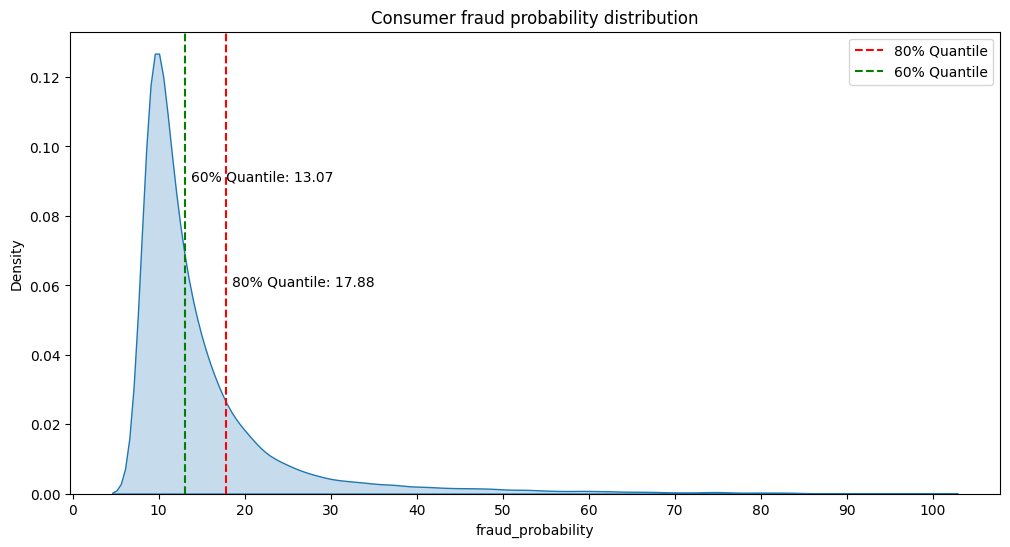

In [55]:
plt.figure(figsize=(12, 6))
plt.xticks(range(0, 101, 10))

# consumer fraud probability distribution
kde = sns.kdeplot(consumer_prob['fraud_probability'], fill=True)
plt.title("Consumer fraud probability distribution")

# 80 quantile
quantile_80 = stats.scoreatpercentile(consumer_prob['fraud_probability'], 80)
plt.axvline(x=quantile_80, color='red', linestyle='--', label='80% Quantile')
plt.text(quantile_80 + 0.7, 0.06, f'80% Quantile: {quantile_80:.2f}', color='black', fontsize=10)

# 60 quantile
quantile_60 = stats.scoreatpercentile(consumer_prob['fraud_probability'], 60)
plt.axvline(x=quantile_60, color='green', linestyle='--', label='60% Quantile')
plt.text(quantile_60 + 0.7, 0.09, f'60% Quantile: {quantile_60:.2f}', color='black', fontsize=10)

plt.legend()
plt.show()

# # paint quantile area only inside distribution but not of the whole rectangle, 0-60% to green, 60-80% to yellow, 80-100% to red
# plt.axvspan(consumer_prob['fraud_probability'].min(), quantile_60, alpha=0.2, color='green')
# plt.axvspan(quantile_60, quantile_80, alpha=0.2, color='yellow')
# plt.axvspan(quantile_80, consumer_prob['fraud_probability'].max(), alpha=0.2, color='red')

### 1.2.2 Merchant fraud prob visualization 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


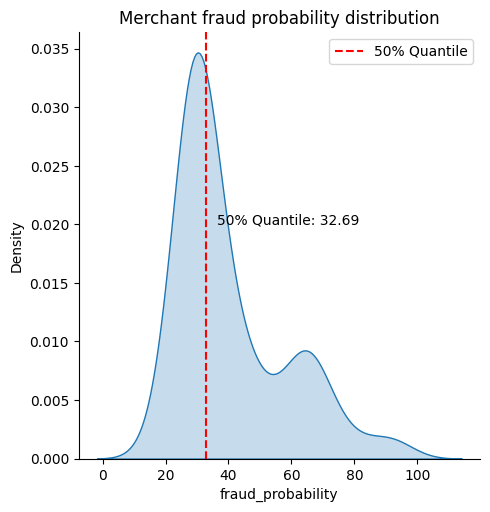

In [50]:
# draw merchant fraud probability distribution
sns.displot(merchant_prob, x="fraud_probability", kind="kde", fill=True)
plt.title("Merchant fraud probability distribution")

# 50 quantile
quantile_50 = stats.scoreatpercentile(merchant_prob['fraud_probability'], 50)
plt.axvline(x=quantile_50, color='red', linestyle='--', label='50% Quantile')
plt.text(quantile_50 + 3.5, 0.02, f'50% Quantile: {quantile_50:.2f}', color='black', fontsize=10)

plt.legend()
plt.show()

### 1.2.3 Consumer amount total

In [14]:
# calculate consumer amount for each individual merchant
merchant_amount = transaction.groupby(['merchant_abn'])['dollar_value'].sum().reset_index()
merchant_amount['daily_average'] = merchant_amount['dollar_value'] / 365

# filter top 100 merchants
merchant_top_100 = merchant_amount.sort_values(by=['daily_average'], ascending=False).head(100)

merchant_top_100

,merchant_abn,dollar_value,daily_average
1481,39649557865,9.857402e+06,27006.581721
4259,96680767841,9.806731e+06,26867.756585
857,27093785141,9.753404e+06,26721.654342
3576,82368304209,9.753248e+06,26721.226719
3455,79827781481,9.734168e+06,26668.954735
...,...,...,...
129,12771097467,4.932394e+06,13513.408292
71,11439466003,4.882819e+06,13377.587283
1417,38212167834,4.597445e+06,12595.738400
3522,81219314324,4.468822e+06,12243.347321


If we try to merge the fraud probability of merchants to the top 100 merchants, we would find the instance of fraud prob is not sufficient as it only has 141 records and even recorded on date.

We would talk more about merchant_prob and consumer_prob later in the merge section.

In [15]:
# TODO: try to find weighted amount considering merchant fraud probability
# gain merchant fraud probability from merchant_prob through merchant_abn
merchant_prob_subset = merchant_prob[['merchant_abn', 'fraud_probability']]
merchant_top_100 = merchant_top_100.merge(merchant_prob_subset, on='merchant_abn', how='left')

merchant_top_100

,merchant_abn,dollar_value,daily_average,fraud_probability
0,39649557865,9.857402e+06,27006.581721,28.690204
1,96680767841,9.806731e+06,26867.756585,29.555245
2,27093785141,9.753404e+06,26721.654342,29.539473
3,27093785141,9.753404e+06,26721.654342,29.520114
4,27093785141,9.753404e+06,26721.654342,27.582358
...,...,...,...,...
136,12771097467,4.932394e+06,13513.408292,NaN
137,11439466003,4.882819e+06,13377.587283,NaN
138,38212167834,4.597445e+06,12595.738400,NaN
139,81219314324,4.468822e+06,12243.347321,NaN


## 1.3 Merge

### 1.3.1 Consumer Data

Notice, there are null value in merchant fraud prob and consumer fraud prob if we simply merge in consumer_prob/merchant_prob. This lead us to use prediction models to update(predict) left part on these datasets. 

Now, to draw geo spcial picture on consumer shopping amounts and prefer merchants, we don't merge the prob in to the consumer dataset as this would influence the final merge table of the transcation.

In [16]:
# merge tbl_consumer and consumer_details
consumer = pd.merge(tbl_consumer, consumer_details, on='consumer_id', how='left')
consumer.to_csv('../data/curated/consumer/consumer_merge.csv')

### 1.3.2 Merchant Dataset 

We decided not yet to merge merchant details and fraud probability.
We will find a way to evaluate and aggregate merhchant's fraud probability on specific date through a model containing consumer-transcation info. 

### 1.3.3 Transcation 

Note: Merge large to small don't have new nah or duplicates

In [21]:
transaction_consumer = pd.merge(transaction, consumer, on='user_id', how='left')
transaction_consumer.to_parquet('../data/curated/transaction/transaction_consumer.parquet')

In [22]:
transaction_consumer

,user_id,merchant_abn,dollar_value,order_id,order_datetime,name,address,state,postcode,gender,consumer_id
0,1,28000487688,133.226894,0c37b3f7-c7f1-48cb-bcc7-0a58e76608ea,2021-02-28,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503
1,18485,62191208634,79.131400,9e18b913-0465-4fd4-92fd-66d15e65d93c,2021-02-28,Samuel Haynes,9969 Catherine View Apt. 601,VIC,3073,Male,1212819
2,1,83690644458,30.441348,40a2ff69-ea34-4657-8429-df7ca957d6a1,2021-02-28,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503
3,18488,39649557865,962.813341,f4c1a5ae-5b76-40d0-ae0f-cb9730ac325a,2021-02-28,Aaron Sawyer,362 Dixon Islands,WA,6646,Male,1302316
4,2,80779820715,48.123977,cd09bdd6-f56d-489f-81ea-440f4bda933c,2021-02-28,Mary Smith,3764 Amber Oval,NSW,2782,Female,179208
...,...,...,...,...,...,...,...,...,...,...,...
14195500,11136,77698107389,400.792069,5e68cb94-3eab-4342-83fa-65263eff26b8,2022-10-26,Terry Howell,4358 Robert Locks,QLD,4707,Male,841591
14195501,11136,24852446429,5.384811,ba2ce936-ae49-4b70-a4b1-e8f8bacaefb3,2022-10-26,Terry Howell,4358 Robert Locks,QLD,4707,Male,841591
14195502,11136,63685007785,48.129887,a6194c61-ae7a-4037-a425-2dd7cda42fb7,2022-10-26,Terry Howell,4358 Robert Locks,QLD,4707,Male,841591
14195503,11137,85502310765,4.768752,72a3639e-25d5-4bcc-9e8b-26e737b8c0e4,2022-10-26,Mr. Kenneth Reyes MD,01577 Shawn Square,VIC,3413,Male,505728


In [18]:
# calculate the average dollar_value per postcode in transaction_consumer dataset
total_dollar_per_postcode = transaction_consumer.groupby('postcode')['dollar_value'].sum().reset_index()

# Display the result
print(total_dollar_per_postcode)

print(total_dollar_per_postcode.sort_values(by='dollar_value', ascending=False))

     postcode  dollar_value
0        1001  8.397177e+05
1        1002  7.256738e+05
2        1003  1.350344e+06
3        1004  1.108128e+06
4        1005  8.509400e+05
...       ...           ...
3160      907  1.163569e+06
3161      909  5.051053e+05
3162     9464  8.748950e+05
3163     9726  6.105660e+05
3164     9999  4.237027e+05

[3165 rows x 2 columns]
     postcode  dollar_value
253      1819  1.896759e+06
3069     7320  1.847480e+06
2746     6470  1.815983e+06
1271     3415  1.783438e+06
1778     4215  1.730325e+06
...       ...           ...
2875     6847  9.273296e+04
1692     4051  9.191074e+04
2545     6111  9.177287e+04
384      2126  8.889549e+04
184      1355  8.813675e+04

[3165 rows x 2 columns]


In [20]:
total_dollar_per_postcode.to_csv('../data/curated/external/dollar_amount_per_postcode.csv')